### 1. Разбиваем файл с твитами на тренировочную, валидационную и тестовую выборки

In [1]:
from src.data_utils import process_text

process_text('./data/')

Обработка текста...


100%|██████████| 1600498/1600498 [00:12<00:00, 132807.43it/s]



Перемешиваем данные...
Размер тренировочного набора: 1280398 ( 80.0%)
Размер валидационного набора: 160050 ( 10.0%)
Размер тестового набора: 160050 ( 10.0%)

Сохраняем разделенные датасеты...
Тренировочный набор сохранен в: ./data/train.csv
Валидационный набор сохранен в: ./data/val.csv
Тестовый набор сохранен в: ./data/test.csv


### 2. Тренируем собственную модель

Для начала импортируем все необходимые модули

In [3]:
import os
import random

import pandas as pd
import torch
from transformers import AutoTokenizer

from src.data_utils import split_text_3_4
from src.eval_lstm import generate_and_evaluate
from src.lstm_model import SimpleLSTM
from src.lstm_train import train_model_with_rouge
from src.next_token_dataset import create_dataloader


Загрузим датасеты и создадим даталоадеры

In [4]:
data_dir = './data/'

# Создаем директорию для чекпоинтов
save_directory = "models"
os.makedirs(save_directory, exist_ok=True)

# Загружаем токенизатор
print('Загрузка токенизатора...')
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Добавляем специальные токены для начала/конца
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print('Загрузка тренировочного датасета...')
train_data = pd.read_csv(f'{data_dir}train.csv')
train_texts = (
    train_data['tweet'] if 'tweet' in train_data.columns
    else train_data.iloc[:, 0]
)

print('Загрузка валидационного датасета...')
val_data = pd.read_csv(f'{data_dir}val.csv')
val_texts = (
    val_data['tweet'] if 'tweet' in val_data.columns
    else val_data.iloc[:, 0]
)

print('Загрузка тестового датасета...')
test_data = pd.read_csv(f'{data_dir}test.csv')
texts = test_data['tweet'].dropna().tolist()
selected_texts = random.sample(texts, 10)

# Создаем Dataloader'ы
print('Создание даталоадеров...')
train_dataloader = create_dataloader(train_texts, tokenizer)
val_dataloader = create_dataloader(val_texts, tokenizer)

Загрузка токенизатора...
Загрузка тренировочного датасета...
Загрузка валидационного датасета...
Загрузка тестового датасета...
Создание даталоадеров...
Количество батчей в dataloader: 5002

Пример батча:
input_ids shape: torch.Size([256, 37])
attention_mask shape: torch.Size([256, 37])
labels shape: torch.Size([256, 37])

Пример данных (первые 2 элемента батча):

Элемент 0: 
Вход: allergic test ahhhh i m
Цель: test ahhhh i m scared

Элемент 1: 
Вход: mundah i don t know if the city could handle the whole group of you in one place are all the restraining orders lifted
Цель: ##ndah i don t know if the city could handle the whole group of you in one place are all the restraining orders lifted yet
Количество батчей в dataloader: 626

Пример батча:
input_ids shape: torch.Size([256, 34])
attention_mask shape: torch.Size([256, 34])
labels shape: torch.Size([256, 34])

Пример данных (первые 2 элемента батча):

Элемент 0: 
Вход: leave in
Цель: in hours

Элемент 1: 
Вход: tanyaemma i m sad we d

Из выводимых выше данных видно, что даталоадер построен на том, что входные токены для обучения модели и их референсы сдвинуты относительно друг друга на один токен. В процессе обучения будут периодически накапливаться метрики ROUGE посчитанные именно на сравнении двух этих соответственно сдвинутых последовательностей. Поэтому результат будет достаточно высок. Но это даст представление об улучшении качества обучения модели с каждой эпохой.


Запустим процесс обучения модели с периодическим измерением метрик на валидационной выборке (после каждой эпохи) и сохранением показателей в память TrainHistory для постраения графиков.

In [5]:
# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Создаем модель
vocab_size = len(tokenizer)
model = SimpleLSTM(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2
)

print(f"\nМодель создана:")
print(f"  Параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Размер словаря: {vocab_size}")

# Обучаем модель
trained_model, history = train_model_with_rouge(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    selected_texts=selected_texts,
    tokenizer=tokenizer,
    device=device,
    num_epochs=5,
    learning_rate=0.001,
    eval_every=50,  # Каждые 50 шагов
    save_dir=save_directory,
)


Используемое устройство: cuda

Модель создана:
  Параметров: 12,672,570
  Размер словаря: 30522


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Начинаем обучение на cuda...
Размер словаря: 30522


Epoch 1/5 [Train]: 100%|██████████| 5002/5002 [15:29<00:00,  5.38it/s, loss=5.2979, avg_loss=10.3691, lr=0.001000]



Epoch 1/5 завершена



Train Loss: 5.7521
Val Loss: 5.2379
Val ROUGE-1: 0.207
Val ROUGE-2: 0.033
Val ROUGE-L: 0.190


  Примеры генерации:
    'I love' -> 'i lovee and i m not going to be a long day of school today i m going to bed now'
    'The weather is' -> 'the weather ise and i m not going to be a good day i m so tired i m going to bed'
    'Machine learning' -> 'machine learninge and i m not going to be a long day of school today i m going to bed now'



Epoch 2/5 [Train]: 100%|██████████| 5002/5002 [16:10<00:00,  5.16it/s, loss=5.0713, avg_loss=9.1756, lr=0.001000]



Epoch 2/5 завершена



Train Loss: 5.0900
Val Loss: 5.0238
Val ROUGE-1: 0.220
Val ROUGE-2: 0.037
Val ROUGE-L: 0.202


  Примеры генерации:
    'I love' -> 'i lovee and i m not going to the gym and i m not going to the gym and i m'
    'The weather is' -> 'the weather isk out of the world of the world is a good movie i m going to miss my baby girl'
    'Machine learning' -> 'machine learninge and i m not going to the gym and i m not going to the gym and i m'



Epoch 3/5 [Train]: 100%|██████████| 5002/5002 [16:45<00:00,  4.97it/s, loss=4.9635, avg_loss=8.8696, lr=0.001000]



Epoch 3/5 завершена



Train Loss: 4.9203
Val Loss: 4.9349
Val ROUGE-1: 0.226
Val ROUGE-2: 0.040
Val ROUGE-L: 0.207


  Примеры генерации:
    'I love' -> 'i lovee and i m not a fan of the world is a good day to be back in the morning'
    'The weather is' -> 'the weather ise and i m not sure if i can get a new phone today i m going to miss my'
    'Machine learning' -> 'machine learninge and i m not a fan of the world is a good day to be back in the morning'



Epoch 4/5 [Train]: 100%|██████████| 5002/5002 [17:25<00:00,  4.79it/s, loss=4.8531, avg_loss=8.6984, lr=0.001000]



Epoch 4/5 завершена



Train Loss: 4.8253
Val Loss: 4.8825
Val ROUGE-1: 0.230
Val ROUGE-2: 0.041
Val ROUGE-L: 0.211


  Примеры генерации:
    'I love' -> 'i loveely i know i m not going to the gym with my mom and dad are going to be'
    'The weather is' -> 'the weather isl and i m not going to the gym today and i m going to miss my best friend i'
    'Machine learning' -> 'machine learninge and the new moon trailer is amazing i love you guys i m going to bed now i have'



Epoch 5/5 [Train]: 100%|██████████| 5002/5002 [18:06<00:00,  4.61it/s, loss=4.7982, avg_loss=8.5833, lr=0.001000]



Epoch 5/5 завершена



Train Loss: 4.7614
Val Loss: 4.8512
Val ROUGE-1: 0.231
Val ROUGE-2: 0.042
Val ROUGE-L: 0.213


  Примеры генерации:
    'I love' -> 'i lovee and i are going to have a shower and i m off to bed i m going to bed'
    'The weather is' -> 'the weather isk i m so sorry i missed you last night i m so tired i m so tired i m'
    'Machine learning' -> 'machine learningl and i are going to have a shower and i m off to bed i m going to bed'



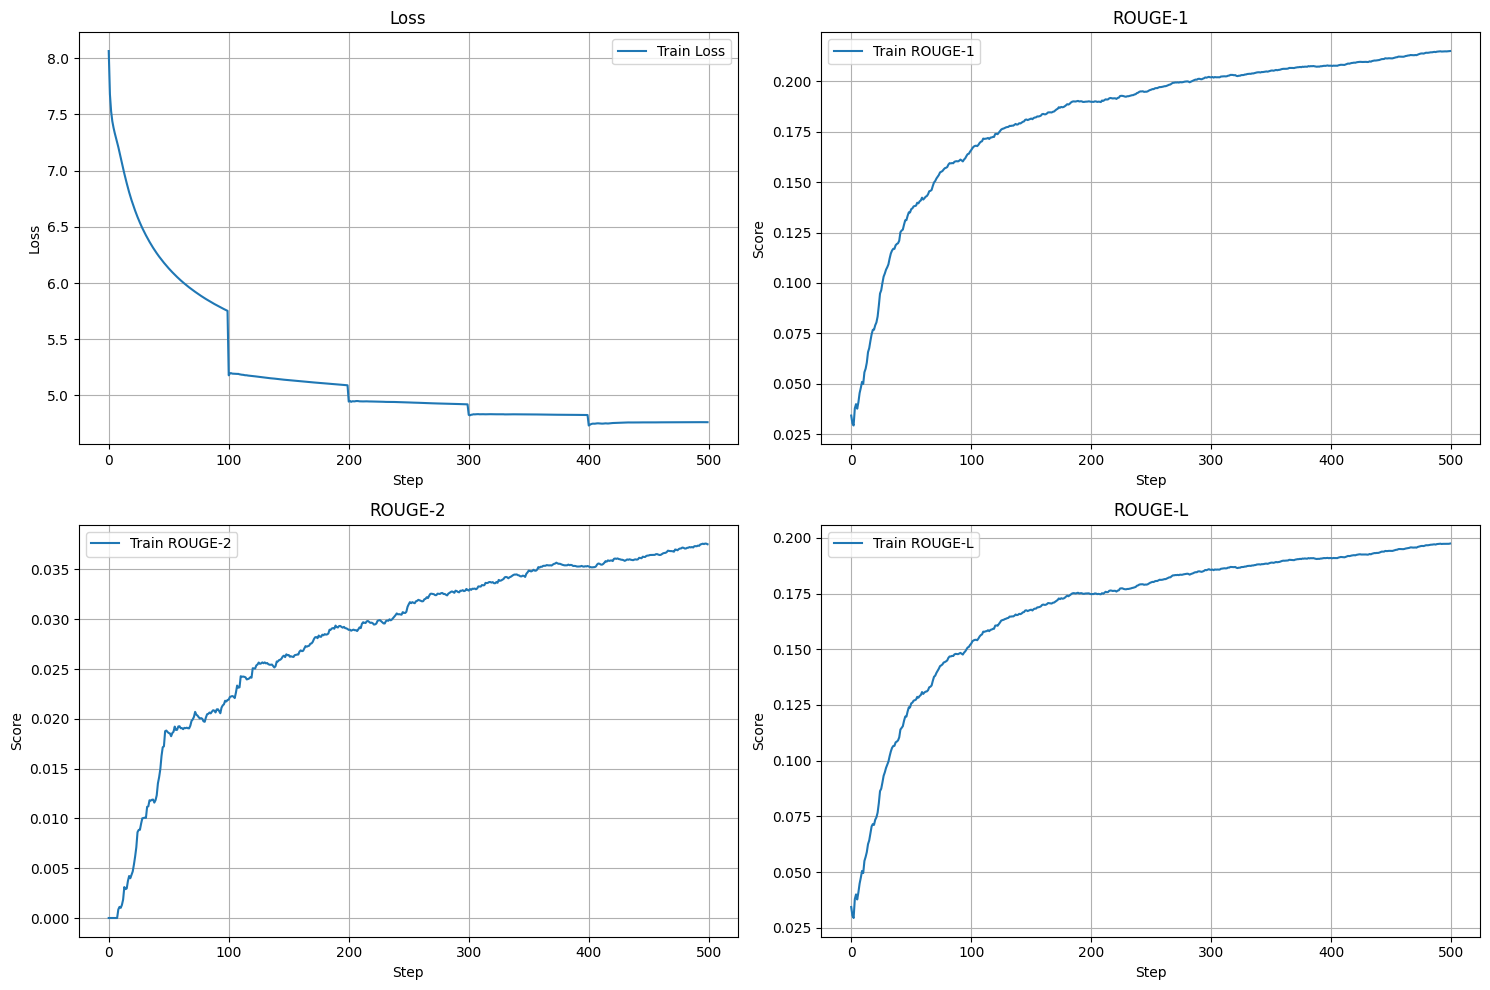

In [6]:
# Визуализируем историю обучения
history.plot_training_history()


Как видно из истории обучения функция потерь с каждой эпохой обучения падает, соответственно модель обучается правильно.

In [7]:
# Финальная оценка
print("\n" + "=" * 60)
print("Финальная оценка модели:")
print("=" * 60)

prompts = []
references = []
for text in selected_texts:
    split_data = split_text_3_4(text, tokenizer)
    prompts.append(split_data['prompt'])
    references.append(split_data['target'])

results = generate_and_evaluate(
    model, tokenizer, prompts, references, device,
)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Финальная оценка модели:


Генерация текста: 100%|██████████| 10/10 [00:00<00:00, 64.30it/s]

'after watching the tony awards my whole being aches and yearns to act sing dance' -> 'after watching the tony awards my whole being aches and yearns to act sing dance ##e and i m so sad i missed'
'skimboarding in laguna with the best uncle' -> 'skimboarding in laguna with the best uncle ##e and the new moon trailer'
'i need' -> 'i need ##e to do'
'not really wanting to go back to vermont gonna' -> 'not really wanting to go back to vermont gonna ##e the sun and then i'
'breakfast getting ready then yukon for my ortho appointment and shopping the sucky part about all this' -> 'breakfast getting ready then yukon for my ortho appointment and shopping the sucky part about all this ##ammings and a new one for me'
'dubay whoa look who s on' -> 'dubay whoa look who s on ##e and i m not'
'seriously need to go to bed with' -> 'seriously need to go to bed with ##e and the new moon'
'fourteen hours later i m still having the worst allergy flare up in my life from shooting an' -> 'fourteen hours l

rouge1: 0.0325
rouge2: 0.0000
rougeL: 0.0325
rougeLsum: 0.0325


При окончательной оценки качества обученной модели можно сделать вывод о том, что видны осмысленные дополнения входных последовательностей текста.

Измерение метрик ROUGE в данной финальной оценке построено на сравнении окончательных последовательностей на выходе обученной модели c их эталонами, не учитывая входную последовательность. Поэтому метрики ROUGE немного ниже, чем измеренные в процессе обучения. Также они не совсем подходят для оценки качества модели автодополнения текста, а скорее для оценки моделей суммаризации текста. Такие же невысокие показатели метрик видны при замерах на генерации текста с помощью предобученного трансформера `distilgpt2`.

In [11]:
import random

import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.data_utils import split_text_3_4
from src.eval_lstm import generate_and_evaluate

model_name = 'distilgpt2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)
model.eval() 

print('Загрузка тестового датасета...')
test_data = pd.read_csv('./data/test.csv')
texts = test_data['tweet'].dropna().tolist()
selected_texts = random.sample(texts, 10)

prompts = []
references = []
for text in selected_texts:
    split_data = split_text_3_4(text, tokenizer)
    prompts.append(split_data['prompt'])
    references.append(split_data['target'])

results = generate_and_evaluate(model, tokenizer, prompts, references, device)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Загрузка тестового датасета...


Генерация текста: 100%|██████████| 10/10 [00:00<00:00, 29.86it/s]


'njrunnerfred penn forest rd was a long up hill but the grade was not too bad well' -> 'njrunnerfred penn forest rd was a long up hill but the grade was not too bad well .
In fact, I think'
'digital joy i have my tv desktop pc dvd recorder vhs recorder ps all set up and working' -> 'digital joy i have my tv desktop pc dvd recorder vhs recorder ps all set up and working  on a laptop.
I'm'
'it s going to be a loooooong day i don t see myself eating nething today and probably' -> 'it s going to be a loooooong day i don t see myself eating nething today and probably  I'll have some time tomorrow.'
'debindenver if it comes to that i ll' -> 'debindenver if it comes to that i ll  l.i'
'ibnandassociate thanks for' -> 'ibnandassociate thanks for  the support and encouragement'
'sick i m going with swine flu just' -> 'sick i m going with swine flu just  like that,'
'goodnight twitter shits been really weird with me lately' -> 'goodnight twitter shits been really weird with me lately .
I'm'
'adon

## Вывод

Для задач автодополнения текста лучше использовать предобученный трансформер, т.к.:
- лучше благодаря предобучению на огромной выборке текстов, контекста и сложных языковых паттернов;
- требует лишь тонкой настройки на специфичных данных;
- эффективно обрабатывает длинные контексты.

Однако LSTM имеет смысл использовать, если:
- использовать на текстах с уникальной структурой, например, медицинские рецепты;
- ограничения на размер модели и скорость работы;
- нет доступа к GPU.
